In [41]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
data = pd.read_csv('/content/drive/My Drive/spam.csv',encoding = "'latin'")

In [44]:
data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [45]:
data["text"] = data.v2
data["spam"] = data.v1

# Splitting data

In [46]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2) 

In [47]:
data.info

<bound method DataFrame.info of         v1  ...  spam
0      ham  ...   ham
1      ham  ...   ham
2     spam  ...  spam
3      ham  ...   ham
4      ham  ...   ham
...    ...  ...   ...
5567  spam  ...  spam
5568   ham  ...   ham
5569   ham  ...   ham
5570   ham  ...   ham
5571   ham  ...   ham

[5572 rows x 7 columns]>

In [48]:
emails_train.shape

(4457,)

# Preprocessing

In [49]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'no messageno responcewhat happend'

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [51]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

# Tokenize

In [52]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [53]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

[38, 1816, 1817, 1500]

# Padding

In [54]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([   0,    0,    0, ..., 1816, 1817, 1500], dtype=int32)

# Model

In [55]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [56]:
# create the model
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
9/9 [==============================] - 4s 403ms/step - loss: 0.6541 - accuracy: 0.8640 - val_loss: 0.5694 - val_accuracy: 0.8709
Epoch 2/20
9/9 [==============================] - 3s 344ms/step - loss: 0.4541 - accuracy: 0.8647 - val_loss: 0.4021 - val_accuracy: 0.8709
Epoch 3/20
9/9 [==============================] - 3s 346ms/step - loss: 0.3917 - accuracy: 0.8647 - val_loss: 0.3638 - val_accuracy: 0.8709
Epoch 4/20
9/9 [==============================] - 3s 347ms/step - loss: 0.3584 - accuracy: 0.8647 - val_loss: 0.3150 - val_accuracy: 0.8709
Epoch 5/20
9/9 [==============================] - 3s 346ms/step - loss: 0.2935 - accuracy: 0.8647 - val_loss: 0.2305 - val_accuracy: 0.8709
Epoch 6/20
9/9 [==============================] - 3s 347ms/step - loss: 0.1922 - accuracy: 0.9116 - val_loss: 0.1690 - val_accuracy: 0.9516
Epoch 7/20
9/9 [==============================] - 3s 349ms/step - loss: 0.1324 - accuracy: 0.9740 - val_loss: 0.1262 - val_accuracy: 0.9632
Epoch 8/20
9/9 [====

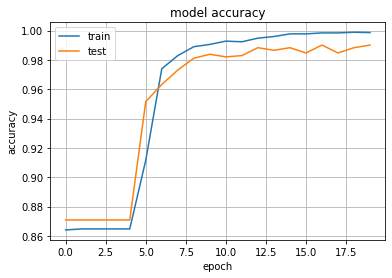

In [58]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [59]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [60]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt  
cf_matrix =confusion_matrix(test_y,y_predict)

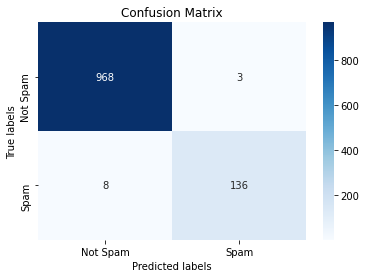

In [61]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [62]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [63]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 97.84%
Recall: 94.44%
F1 Score: 96.11%


In [64]:
accuracy_score(test_y,y_predict)

0.9901345291479821

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# Any results you write to the current directory are saved as output.
data = pd.read_csv("/content/drive/My Drive/spam.csv",encoding='latin-1')

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [66]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"class", "v2":"text"})
data.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [67]:
data['length'] = data['text'].apply(len)
data.head()

,class,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [68]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [69]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')

def pre_process(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence


In [70]:
textFeatures = data['text'].copy()
textFeatures = textFeatures.apply(pre_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(textFeatures)

features_train, features_test, labels_train, labels_test = train_test_split(features, data['class'], test_size=0.2, random_state=111)

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(features_train, labels_train)
prediction = svc.predict(features_test)

In [72]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt  
cf_matrix =confusion_matrix(labels_test,prediction)

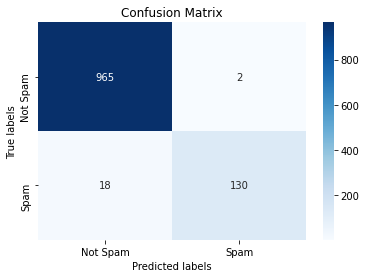

In [73]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [74]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels_test,prediction, average='macro')

(0.9832685964425537, 0.9381550630257973, 0.9591575091575091, None)

In [75]:
accuracy_score(labels_test,prediction)

0.9820627802690582

In [76]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.2)
mnb.fit(features_train, labels_train)
prediction = mnb.predict(features_test)

In [77]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt  
cf_matrix =confusion_matrix(labels_test,prediction)

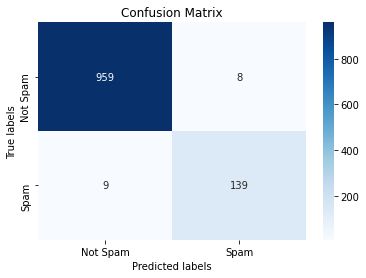

In [78]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [79]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(labels_test,prediction, average='macro')

(0.96814035531568, 0.9654580899410268, 0.9667936758200849, None)

In [80]:
accuracy_score(labels_test,prediction)

0.9847533632286996